In [10]:
# Template for the SMC competition for modeling neurons in the superior colliculus

import math
import numpy as np
import h5py

# Please download the file SCNeuronModelCompetition.mat from here.
# https://github.com/santacruzml/fall-17-scml-competition/releases/download/0.0-data/SCNeuronModelCompetition.mat

datafile = h5py.File('SCNeuronModelCompetition.mat')
movie = datafile.get('trainingmovie_mini') # movie for training
frhist = datafile.get('FRhist_tr') # firing rate histograms

# a little normalization for the movie (assuming that the movie is 3D array)
def normalize(inputmovie):
    movie_mean = np.mean(inputmovie, axis=(0, 1, 2))
    movie_std = np.std(inputmovie, axis=(0, 1, 2))
    return (inputmovie - movie_mean) / movie_std

movie_norm = normalize(movie)

In [4]:
# here's the moeling part. I'll give just a starting point

import keras
from keras.layers import LSTM, Activation, Dense, BatchNormalization

# It makes a 3-layer LSTM network with batch normalization on each layer.
# No dropout, regularization, convolution structures are used.
# As you see in the summary, most parameters go to the first weight matrix.



movie_chunk_length = movie_norm.shape[1]
movie_pix = movie_norm.shape[2]
nHidden = 100
nLayer = 3
nSCNeu = frhist.shape[2]


model = keras.models.Sequential()
model.add(LSTM(nHidden, input_shape=(movie_chunk_length, movie_pix), return_sequences=True, implementation=2))

for _ in range(nLayer-1):
    model.add(BatchNormalization(momentum=0))
    model.add(Activation('relu'))
    model.add(LSTM(nHidden, return_sequences=True))
    
model.add(BatchNormalization(momentum=0))
model.add(Activation('linear'))
model.add(Dense(nSCNeu))
model.add(Activation('softplus'))
adamopt = keras.optimizers.Adam(lr = 0.001, decay = 1e-7)

# Please make sure to use Poisson likelihood function for the loss function
model.compile(optimizer=adamopt, loss='poisson')
model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(movie_norm, frhist, epochs=200, batch_size=32, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150, 100)          4955600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 100)          400       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 100)          80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 100)          400       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 100)          80400     
__________

InternalError: Dst tensor is not initialized.
	 [[Node: _recv_lstm_1_input_0/_145 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_6560__recv_lstm_1_input_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: batch_normalization_2/moments/sufficient_statistics/Gather/_185 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3571_batch_normalization_2/moments/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

In [19]:
# check if it does a good job in the training dataset
%matplotlib inline
import matplotlib.pyplot as plt

output = model.predict(movie_norm)

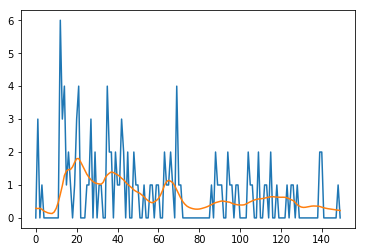

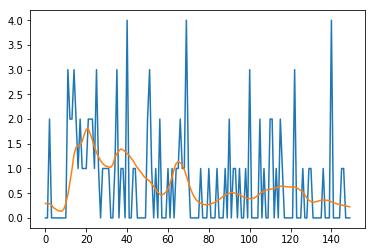

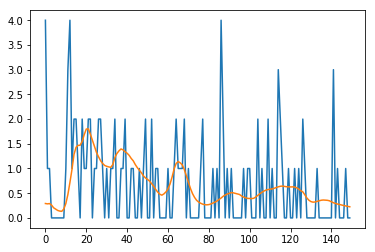

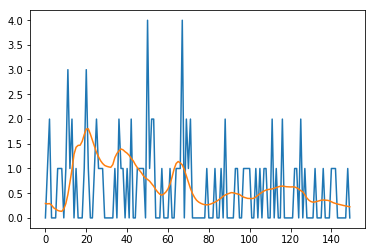

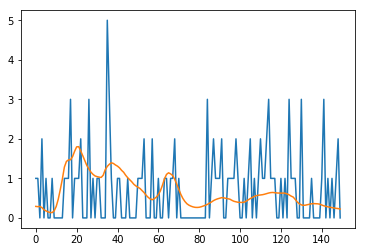

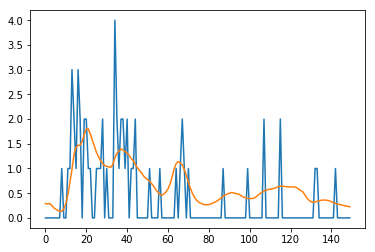

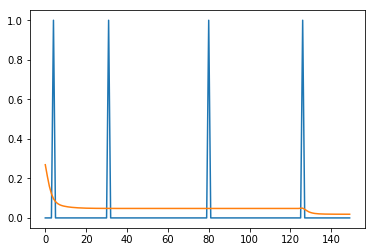

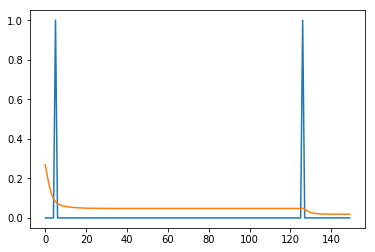

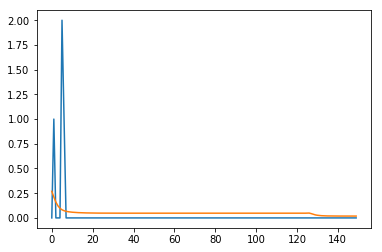

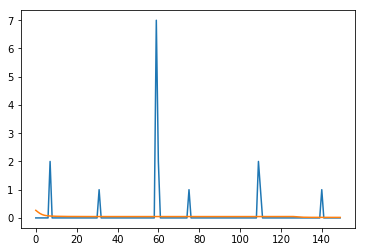

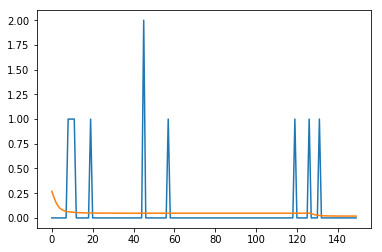

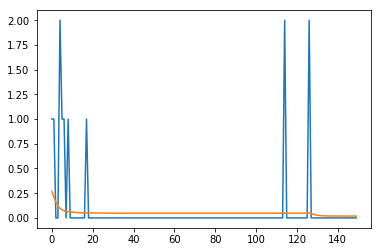

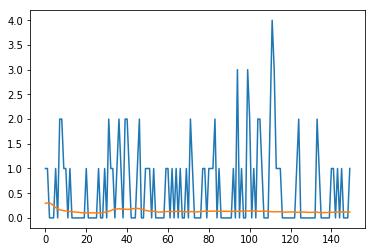

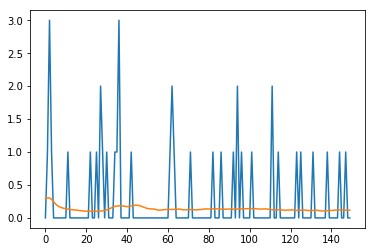

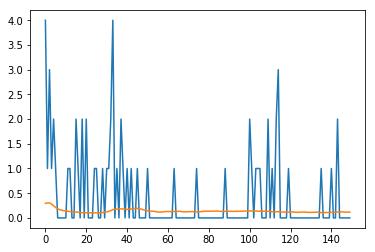

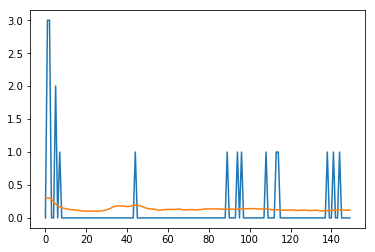

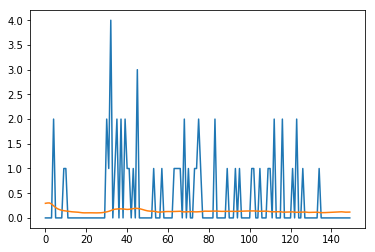

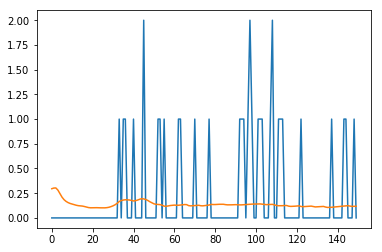

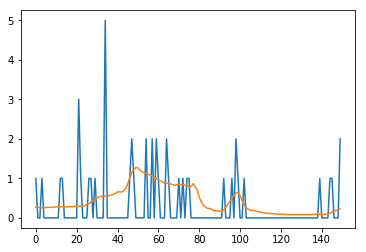

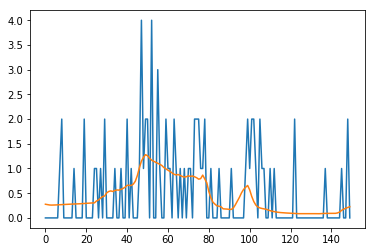

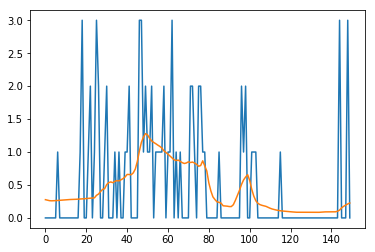

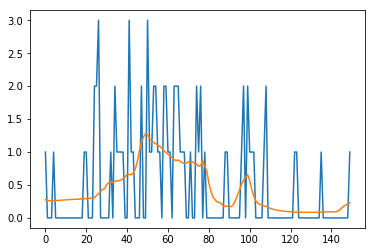

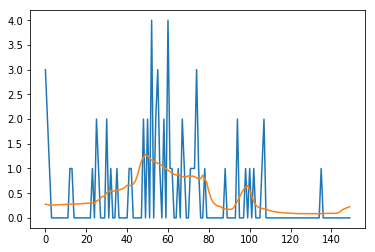

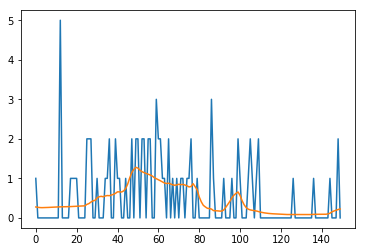

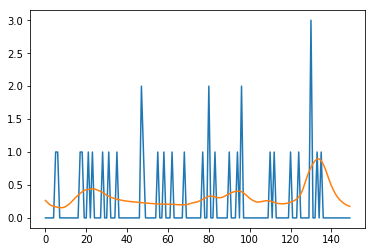

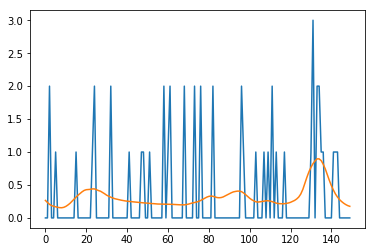

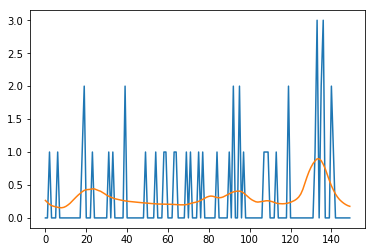

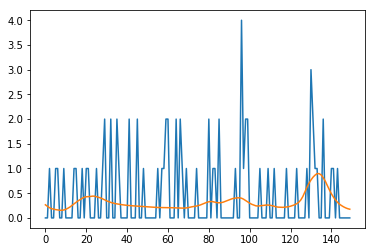

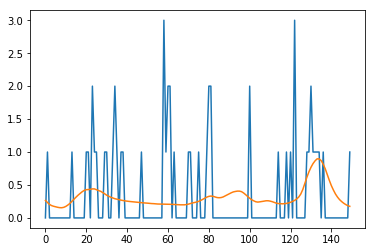

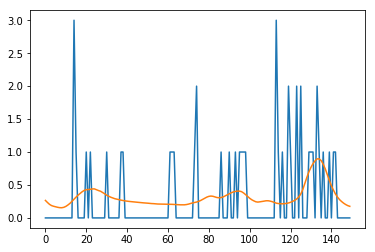

In [23]:
b = 1
for m in range(30):
    n = 31
    # plot the average of 6 trials of the same movie
    plt.plot(np.mean(frhist[(m*b):(m+1)*b, :, n], axis=0))
    
    # plot the output of the network
    plt.plot(np.mean(output[m*b:(m+1)*b,:,n], axis=0))
    plt.show()
    # last 10 movies should be the validation dataset